### 1. Загрузка данных.
Подключаем библиотеки и скрипты.

In [1]:
import numpy as np 
import pandas as pd

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime 

matplotlib.rcParams.update({'font.size': 14})

In [2]:
# функция для постороения графиков предсказанное vs реальное
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Пути к файлам и директориям.

In [3]:
TRAIN_DATASET_PATH = 'c:/ulka/train.csv'
TEST_DATASET_PATH = 'c:/ulka/test.csv'
SAMPLE_SUBMISSION_DATASET_PATH = 'c:/ulka/sample_submission.csv'

Загрузка данных

#### Описание датасета

- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

In [4]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, encoding='utf-8')
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [5]:
#посмотрим типы признаков
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [6]:
# Приведем некоторые числовые категории (Id, DistrictId) в текстовый тип, так как это категориальные признаки

train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [7]:
train_df.info()
# в признаках LifeSquare и Healthcare_1 есть пропущенные значения
# LifeSquare будем заменять, после обработки Square и KitchenSquare, признак Healthcare_1 выбросим, 
# так как почти половины значений нет, а принцип заполнения не совсем очевиден

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [9]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


### 2. EDA

рассмотрим распределение целевой переменной

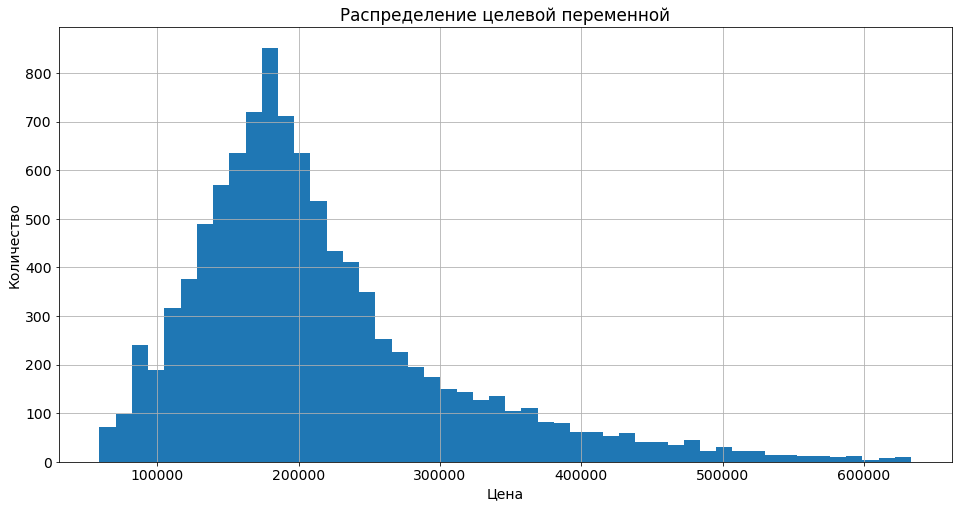

In [10]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=50)
plt.ylabel('Количество')
plt.xlabel('Цена')

plt.title('Распределение целевой переменной')
plt.show()

Распределение целевой переменной похоже на нормальное, только правый хвост длиннее.

Рассмотрим колличественные переменные

In [11]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Рассмотрим рапределения признаков количественных признаков.

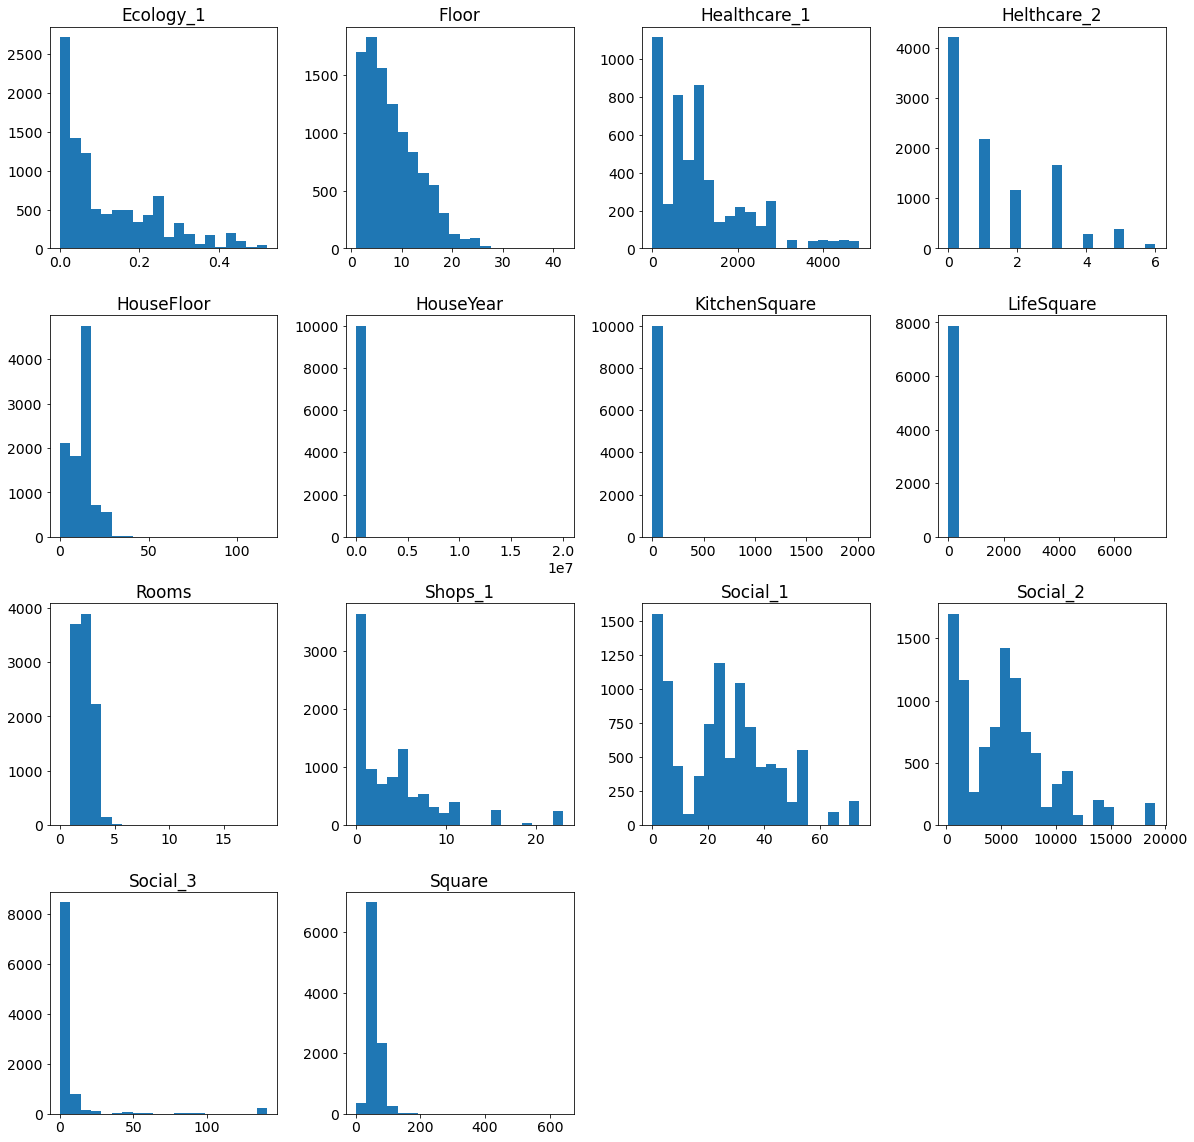

In [12]:
df_num_features = train_df.select_dtypes(include=['float64', 'int64'])
df_num_features.drop('Price', axis=1, inplace=True)

df_num_features.hist(figsize=(20,20), bins=20, grid=False);

Рассмотрим категориальные переменные

In [13]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

Посмотрим на графике распределение категориальных переменных Ecology_2, Ecology_3, Shops_2

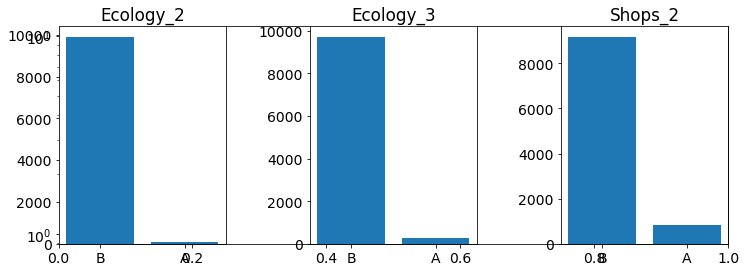

In [14]:
f = plt.figure(figsize=(12,4))
plt.yscale('log')
ax1 = f.add_subplot(131)
x = train_df['Ecology_2'].value_counts().index
y = train_df['Ecology_2'].value_counts()
plt.bar(x, y)
ax1.set_title('Ecology_2')

ax2 = f.add_subplot(132)
x = train_df['Ecology_3'].value_counts().index
y = train_df['Ecology_3'].value_counts()
plt.bar(x, y)
ax2.set_title('Ecology_3')

ax3 = f.add_subplot(133)
x = train_df['Shops_2'].value_counts().index
y = train_df['Shops_2'].value_counts()
plt.bar(x, y)
ax3.set_title('Shops_2')

plt.subplots_adjust(wspace=0.5, hspace=1)

plt.show()

Посмотрим DistrictId

In [15]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
209      1
205      1
196      1
117      1
207      1
Name: DistrictId, Length: 205, dtype: int64

В каких-то районах много домов, в некоторых районах по одному дому

Построим матрицу корреляции

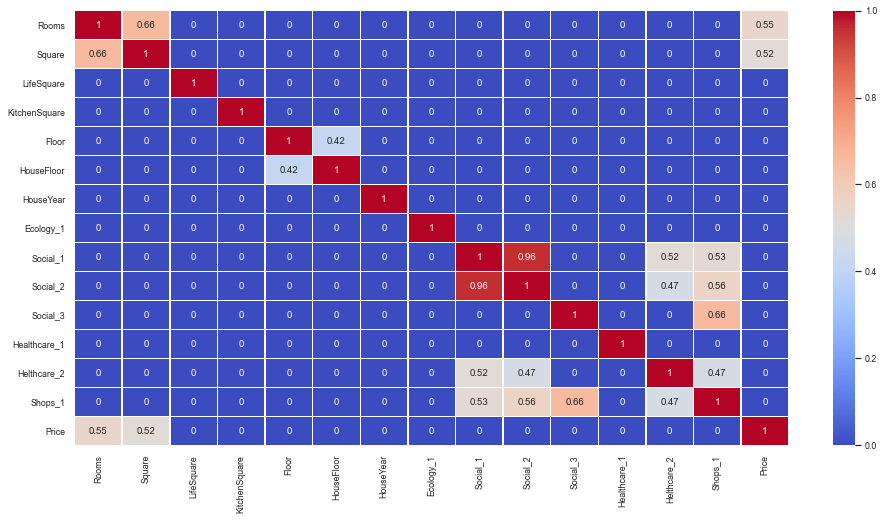

In [16]:
train_df_corr = train_df.corr()
import seaborn as sns
plt.figure(figsize = (16,8))
sns.set(font_scale=0.8)
train_df_corr_round = np.round(train_df_corr, 2)
train_df_corr_round[np.abs(train_df_corr) < 0.3] = 0
sns.heatmap(train_df_corr_round, annot=True, linewidths=.5, cmap='coolwarm')
plt.show()

Площадь довольно сильно коррелирует с количеством комнат, что вполне логично.
Этаж и этажность коррелируют.
Корреляция социальных признаков и медицинских и магазинов, вероятно все эти объекты расположены в одном здании.
Цена достаточно сильно зависит от площади и количества комнат.

### 3. Обработка выбросов и обработка пропусков

In [17]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        self.Square_KitchenSquare_K = None
        self.Square_Square_K = None
        self.Square_LifeSquare_K = None
        self.square_q3 = None
        self.square_q1 = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        self.square_q3 = X['Square'].quantile(.975)
        self.square_q1 = X['Square'].quantile(.025)
        self.Square_KitchenSquare_K = (X['Square'] / X['KitchenSquare']).median()
        self.Square_Square_K = X.loc[(X['Square']<self.square_q3) & (X['Square']>self.square_q1)].median() / X.loc[(X['Square']<self.square_q3) & (X['Square']>self.square_q1)]['Rooms'].median()
        self.Square_LifeSquare_K = (X['Square'].median() / X['LifeSquare']).median()
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        # Убираем выбросы количества комнат
        X.loc[train_df['Rooms'] > 5, 'Rooms'] = 2
        X.loc[train_df['Rooms'] < 1, 'Rooms'] = 1 
      
        # KitchenSquare
        # Изменяем площадь кухни для слишком маленьких и слишком больших  и создаем отдельный признак для изменений 
        # Новую площадь кухни рассчитываем с помощью коэффициента средней площади кухни
        X['KitchenSquare_change'] = 0
        X.loc[~((X['KitchenSquare']>2) & (X['Square']*0.5 >X['KitchenSquare'])), \
                          'KitchenSquare_change'] = 1
        
        X.loc[~((X['KitchenSquare']>2) & (X['Square']*0.5 >X['KitchenSquare'])), \
                      'KitchenSquare'] = round(X['Square'] / self.Square_KitchenSquare_K)
        # Square
        # Если жилая площадь больше площади, меняем их местами
        # Пробовала пересчитать площадь черех коэффициент, как для площади кухни, но результат был хуже
        X['Square'], X['LifeSquare'] = np.where(X['Square'] < X['LifeSquare'],(X['LifeSquare'],X['Square']), (X['Square'],X['LifeSquare']))
        
        # LifeSquare
        # Изменяем жилую площадь и создаем отдельный признак для изменений
        # Если жилая площадь больше площади минус площадь кухни, то пересчитываем жилую площадь через коэффициент
        X['LifeSquare_change'] = 0
        X.loc[(~(X['Square']-X['KitchenSquare']> X['LifeSquare']) & X['LifeSquare']>0), 'LifeSquare_change'] = 1
        
        condition = (~(X['Square']-X['KitchenSquare']> X['LifeSquare']) & X['LifeSquare']>0)
        X.loc[condition, 'LifeSquare'] = X['Square']-X['KitchenSquare']
        
        X.loc[(X['LifeSquare']<10), 'LifeSquare_change'] = 1
        condition = (X['LifeSquare']<10)
        X.loc[condition, 'LifeSquare'] = X['Square']/self.Square_LifeSquare_K
        
        # HouseFloor, Floor
        # меняем этаж квартиры и создаем отдельный признак
        # если этаж 0, то меняем на 1
        # если этаж больше этажности дома, то меняем этаж на этажность
        X['Floor_change'] = 0
        X.loc[(X['Floor']> X['HouseFloor']), 'Floor_change'] = 1
        condition = (X['Floor']> X['HouseFloor'])
        X.loc[condition, 'Floor'] = X['HouseFloor']
        X.loc[(X['HouseFloor']<1), 'Floor_change'] = 1
        X.loc[(X['HouseFloor']<1), 'HouseFloor'] = X['Floor']
        
        
        # HouseYear
        # Если год постройки дома больше текущего года, меняем на текущий год
        current_year = datetime.now().year
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        #X.loc[X['HouseYear'] < 1900, 'HouseYear'] = 1900
                
        #LifeSquare nan
        # заполняем пропуски жилой площади значением площади деленной на коэффициент
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna())
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] / self.Square_LifeSquare_K
        
        # Healthcare_1
        # удаляем признак, так как слишком много пропущенных значений
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        X.fillna(self.medians, inplace=True)
       
        return X

### 4. Построение новых признаков

In [18]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_price_per_square = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
              
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
            
        # средняя стоимость метра в каждом районе
        if y is not None:
            df['Price'] = y.values
            self.district_price_per_square = df.groupby(['DistrictId'])['Price'].agg('median') \
            / df.groupby(['DistrictId'])['Square'].agg('median')  
          
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        # средняя стоимость метра в каждом районе
        self.district_price_per_square.to_dict()
        X['DistrictPrice'] = X['DistrictId'].map(self.district_price_per_square)
        
        self.median_district_price_per_square = X['DistrictPrice'].median()
        X['DistrictPrice'].fillna(self.median_district_price_per_square, inplace=True)
        
        # признак 1 этажа
        X['First_floor'] = 0
        X.loc[(X['Floor']== 1), 'First_floor'] = 1
        
        # признак последнего этажа
        X['Last_floor'] = 0
        X.loc[(X['Floor']== X['HouseFloor']), 'Last_floor'] = 1
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

### 5. Отбор признаков

In [19]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [20]:
#часть признаков не используется, так как от них никакого толка
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['KitchenSquare_change', 'LifeSquare_change',
                     'Floor_change', 'LifeSquare_nan', 'MedPriceByFloorYear','DistrictSize',
                     'IsDistrictLarge','DistrictPrice']

target_name = 'Price'

### 6. Разбиение на train и test

In [21]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [23]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [24]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 32), (3300, 32), (5000, 32))

In [25]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [26]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### 7. Построение модели

Обучение

In [27]:
# лучший результат получен с помощью градиентного бустинга
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=30,
                                     random_state=42,  
                                     n_estimators=2200, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', learning_rate=0.025, loss='huber',
                          max_depth=6, max_features='sqrt', min_samples_leaf=30,
                          n_estimators=2200, random_state=42)

Оценка модели

Train R2:	0.878
Test R2:	0.745


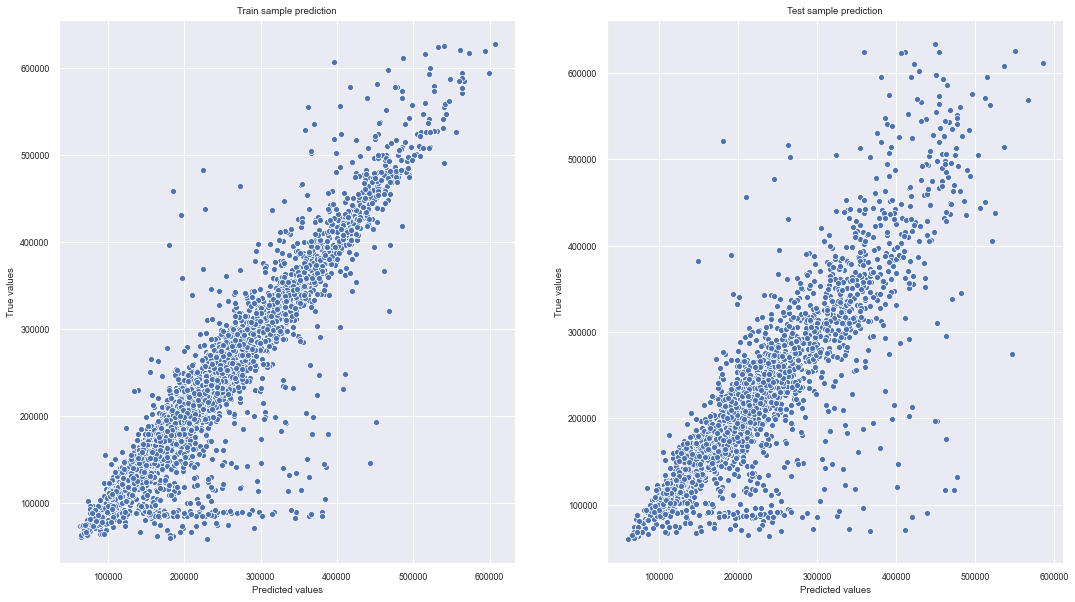

In [28]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Кросс-валидация

In [29]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42))
cv_score

array([0.77044837, 0.74136173, 0.75980726])

In [30]:
cv_score.mean()

0.7572057856608522

Важность признаков

In [31]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.179576
23,DistrictPrice,0.152336
0,Rooms,0.143593
2,LifeSquare,0.110709
22,IsDistrictLarge,0.059468
3,KitchenSquare,0.058846
10,Social_1,0.058448
21,DistrictSize,0.055393
11,Social_2,0.031898
20,MedPriceByFloorYear,0.026459


### 8. Прогнозирование на тестовом датасете

In [32]:
submit = pd.read_csv(SAMPLE_SUBMISSION_DATASET_PATH, encoding='utf-8')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [33]:
predictions = gb_model.predict(test_df)
predictions

array([163263.46663064, 119614.0789126 , 140826.7306178 , ...,
       150477.89836666, 188954.38700995, 288695.35924753])

In [34]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,163263.466631
1,5925,119614.078913
2,960,140826.730618
3,3848,104764.369787
4,746,170667.827574


In [35]:
submit.to_csv('gb_submit.csv', index=False)